In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import anndata as ad

# import function
from cellbender.remove_background.downstream import anndata_from_h5
from cellbender.remove_background.downstream import load_anndata_from_input_and_output

os.chdir(os.getcwd())

## Load data: 
* each batch into separate anndata 
* Add metadata from batchx_raw.h5ad -> save 
* save them into a dictionary 

In [126]:

anndata_dict={}

## Loop over batches and open cellbender output + batchx_raw.h5ad
for batch in os.listdir('../data/cellbender_output/'):
    input_file=os.path.join('../data',batch+'_raw.h5ad')
    output_file=os.path.join('../data/cellbender_output/',batch,batch+'_cb.h5')
    
    adata_batch=load_anndata_from_input_and_output(
                input_file=input_file,
                output_file=output_file,
                input_layer_key='raw',  # this will be the raw data layer
                retain_input_metadata=True,
                analyzed_barcodes_only=True)
    
    ## Read raw data and add its metadata to the cellbender output anndata files
    adata_batch_raw=sc.read_h5ad(input_file)
    meta_colnames=['patient','condition','batch','ribo_frac','mt_frac']
    adata_batch.obs[meta_colnames]=adata_batch_raw.obs.loc[adata_batch.obs.index,meta_colnames]
    
    ## Save the metadata updated cellbender output files
    adata_batch.write_h5ad(os.path.join('../data',batch+'_cellbender_corrected.h5ad'))
    
    ## Calculate basic variables for the obs layer
    adata_batch.obs['n_counts_raw']=adata_batch.layers['raw'].sum(axis=1).A1
    #adata_batch.obs['n_genes']=(adata_batch.layers['raw']>0).sum(axis=1).A1

    anndata_dict[batch]=adata_batch
         

## Plot Barcode rank - UMI plots (__both raw and cellbender corrected counts__)  for each batch

batch Batch1 min n_count 29
batch Batch1 min n_count 0
batch Batch2 min n_count 32
batch Batch2 min n_count 0
batch Batch3 min n_count 76
batch Batch3 min n_count 0
batch Batch4 min n_count 30
batch Batch4 min n_count 0


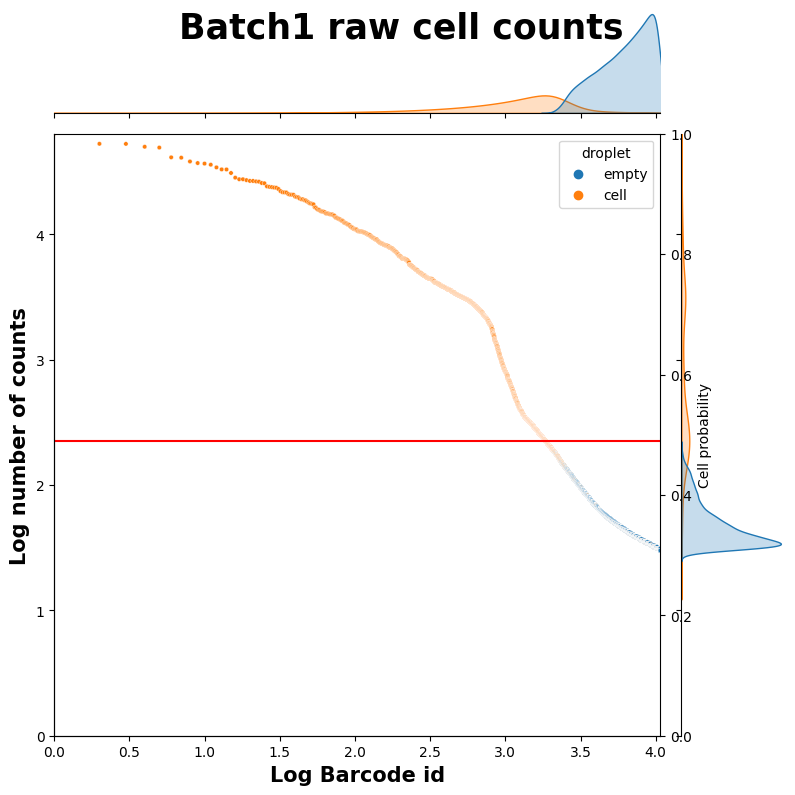

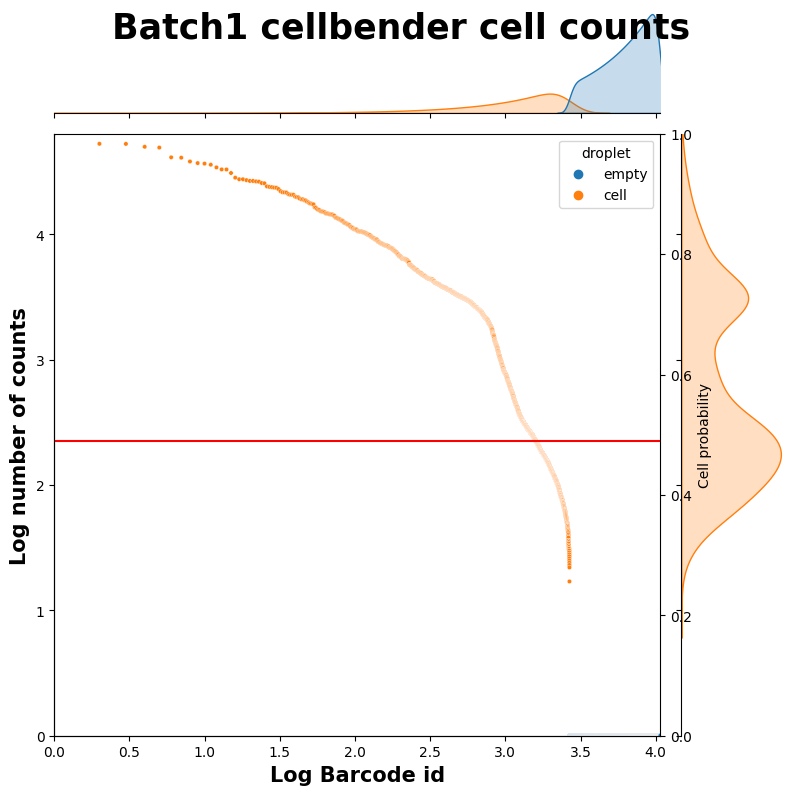

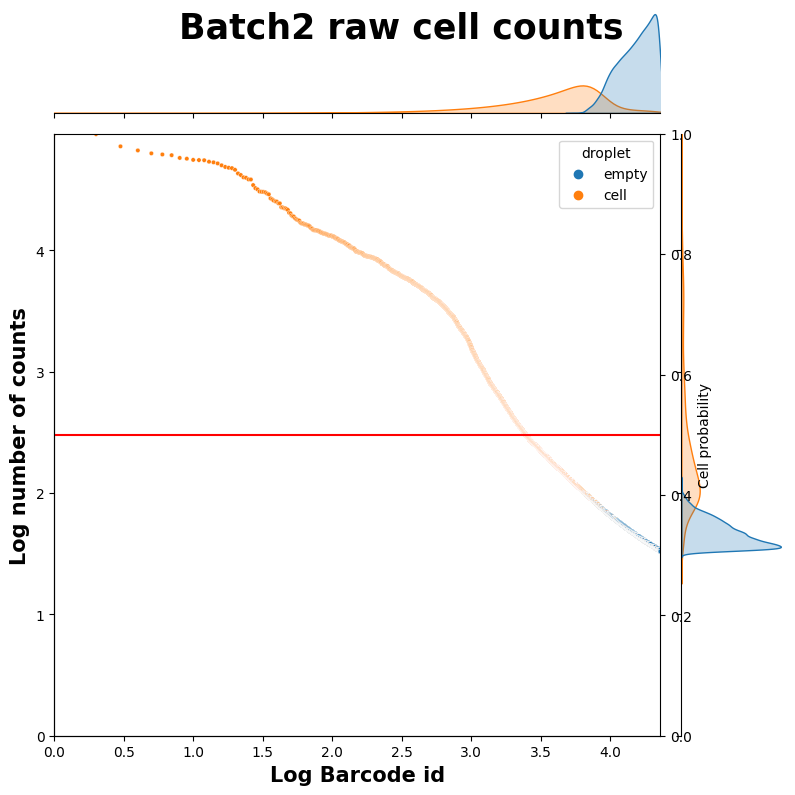

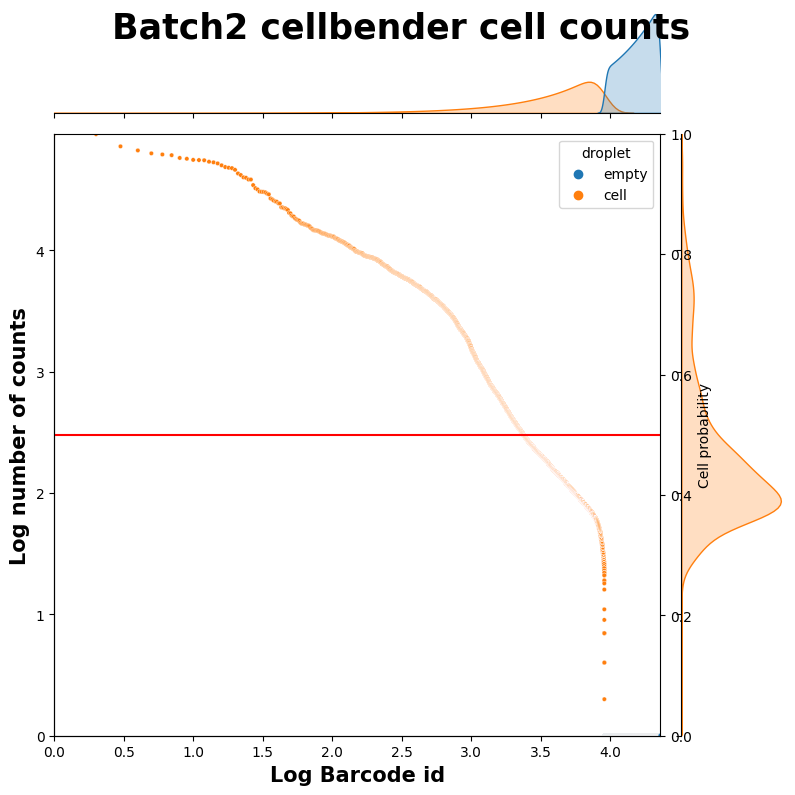

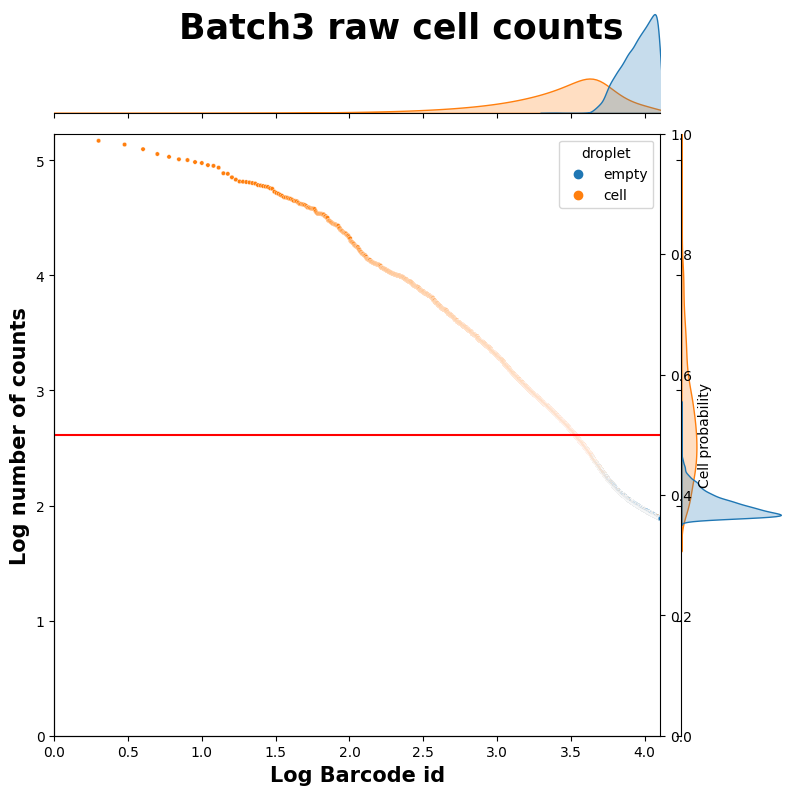

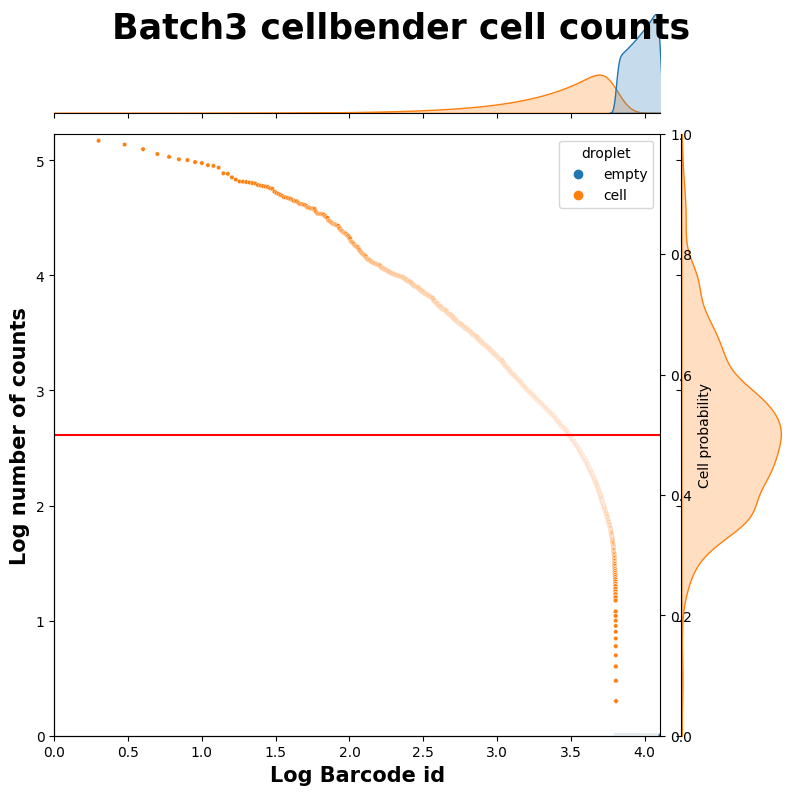

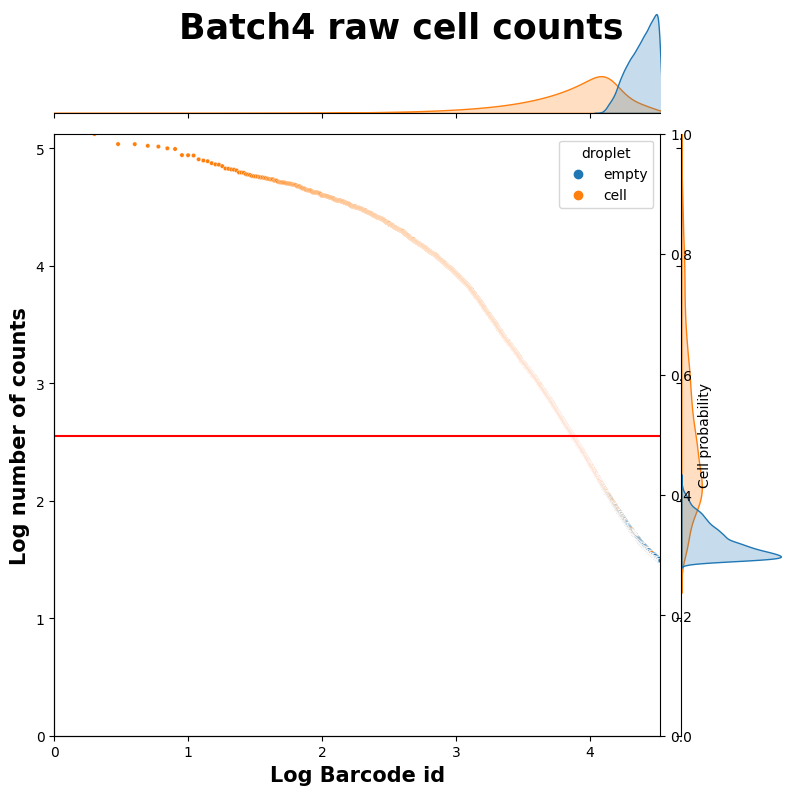

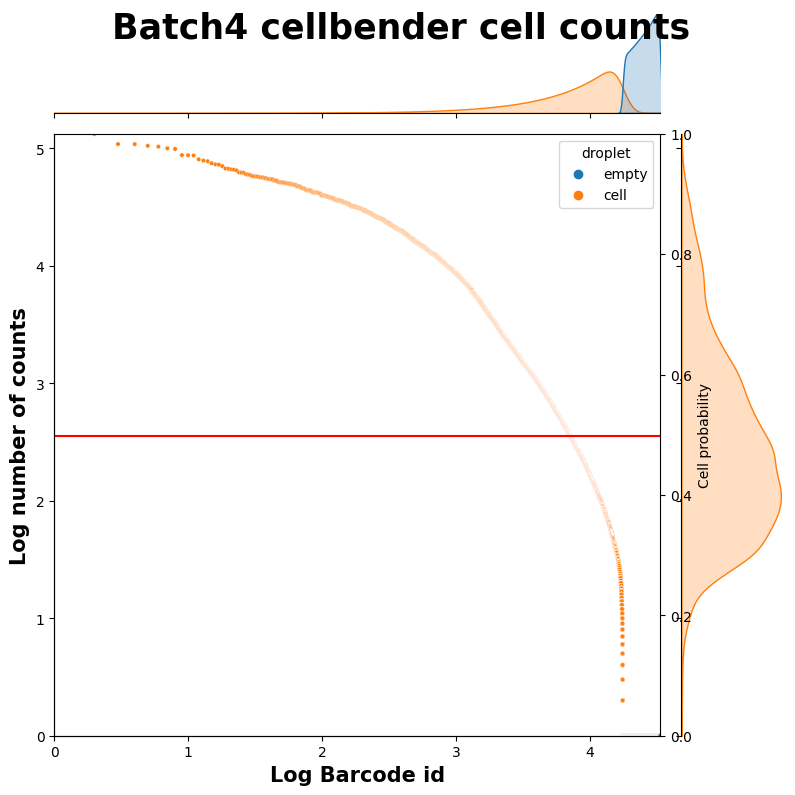

In [116]:
for batch in sorted([*anndata_dict][:]):
    adata_batch=anndata_dict[batch]
    
    for n_count in ['n_raw','n_cellbender']:
    
        plot_df=adata_batch.obs[['cell_probability','cell_size','droplet_efficiency','n_raw', 'n_cellbender','n_genes']].copy()
        plot_df=plot_df.sort_values(by=n_count,ascending=False)
        plot_df['id']=np.arange(1,len(adata_batch.obs)+1)

        batch_plot_df=plot_df.copy()
        print('batch',batch,'min n_count',plot_df[n_count].min())
        batch_plot_df['id']=np.arange(1,len(batch_plot_df)+1)
        batch_plot_df['log_id']=np.log10(batch_plot_df['id'])
        batch_plot_df['log_n_counts']=np.log10(batch_plot_df[n_count]+1)
        batch_plot_df['droplet']=pd.cut(x=batch_plot_df['cell_probability'],bins=[0,0.5,1],labels=['empty','cell'])

        p=sns.jointplot(data=batch_plot_df,x='log_id',y='log_n_counts',hue='droplet',height=8,kind='scatter',s=10,
                        ylim=(0,batch_plot_df['log_n_counts'].max()),
                        xlim=(batch_plot_df['log_id'].min(),batch_plot_df['log_id'].max()))
        # Create a second y-axis on the right side
        ax2=p.ax_joint.twinx()
        # Customize the second y-axis
        ax2.set_ylabel("Cell probability")
        ax2.axhline(batch_plot_df.loc[batch_plot_df['droplet']=='empty','cell_probability'].max(),color='red')

        p.fig.suptitle(str(batch)+' '+n_count.split('_')[1]+' cell counts',fontsize=25,fontweight='bold')
        # Access the matplotlib axes
        ax=p.ax_joint
        ax.set_ylabel('Log number of counts',fontsize=15,fontweight='bold')
        ax.set_xlabel('Log Barcode id',fontsize=15,fontweight='bold')


## Lognormalize data and save them into a dictionary

In [117]:
anndata_dict_norm={}
for batch in [*anndata_dict][:]:
    adata_batch=anndata_dict[batch]
    adata_pp=adata_batch.copy()
    
    sc.pp.normalize_total(adata_pp, layer='raw',target_sum=1e4, exclude_highly_expressed=True)
    sc.pp.log1p(adata_pp)

    adata_pp.obs['n_counts_raw_norm']=adata_pp.X.sum(axis=1).A1
    adata_pp.obs['log_n_counts_raw_norm']=np.log10(adata_pp.obs['n_counts_raw_norm']+1)
    adata_pp.obs['droplet']=pd.cut(x=adata_pp.obs['cell_probability'],bins=[0,0.5,1],labels=['empty','cell'])
    
    sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=15, metric='euclidean')
    sc.tl.umap(adata_pp)
    anndata_dict_norm[batch]=adata_pp
    

/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


##  Plot UMAPs: Erythtocyte markers, droplet identity, cell counts

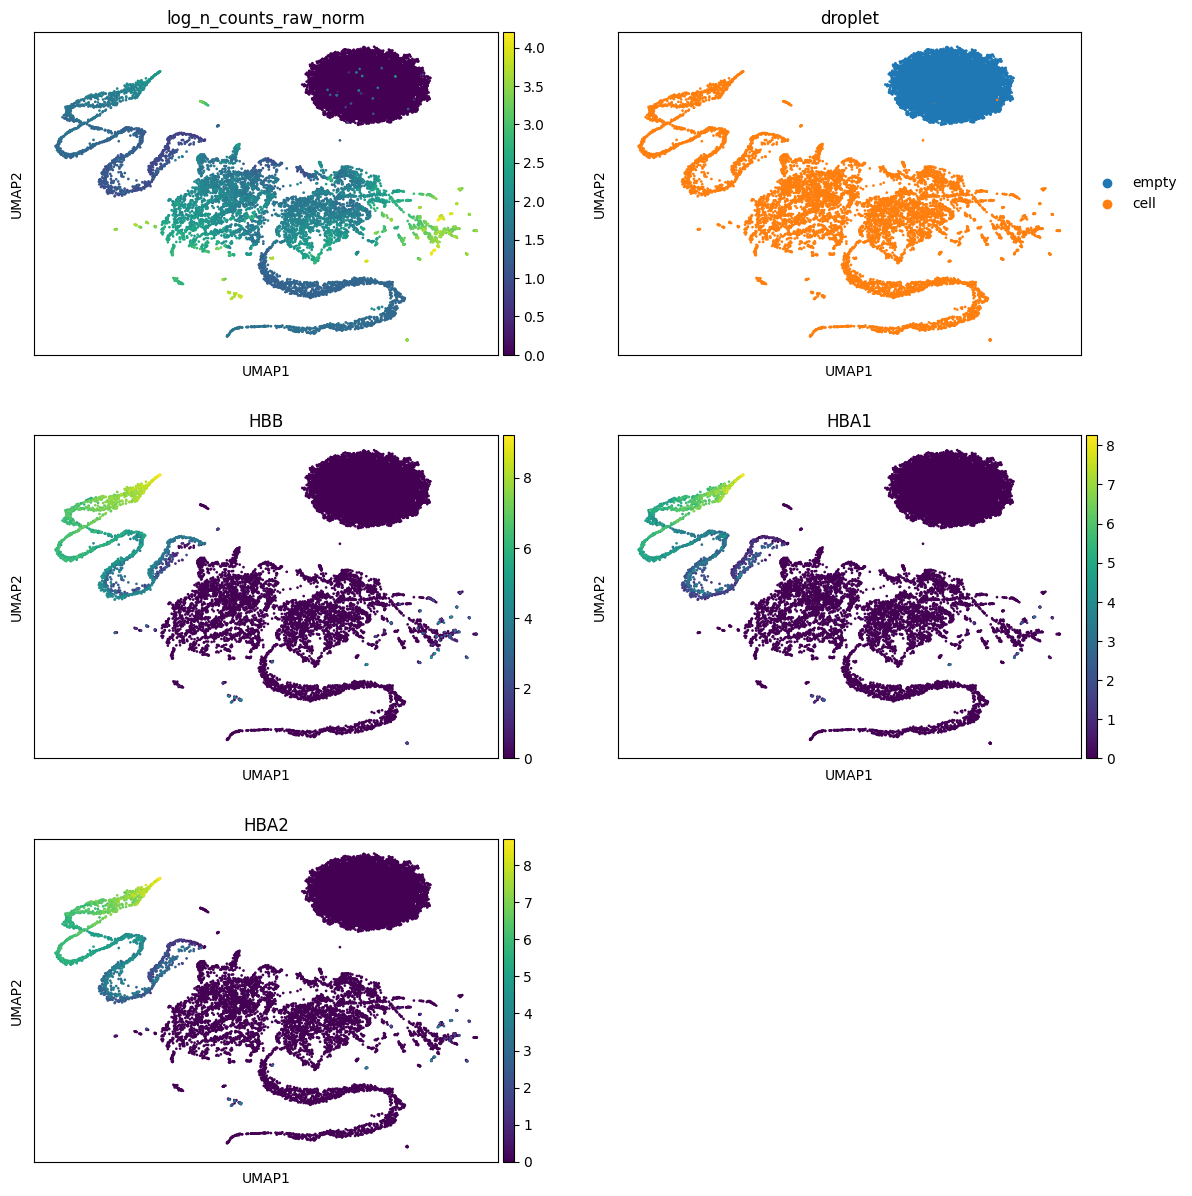

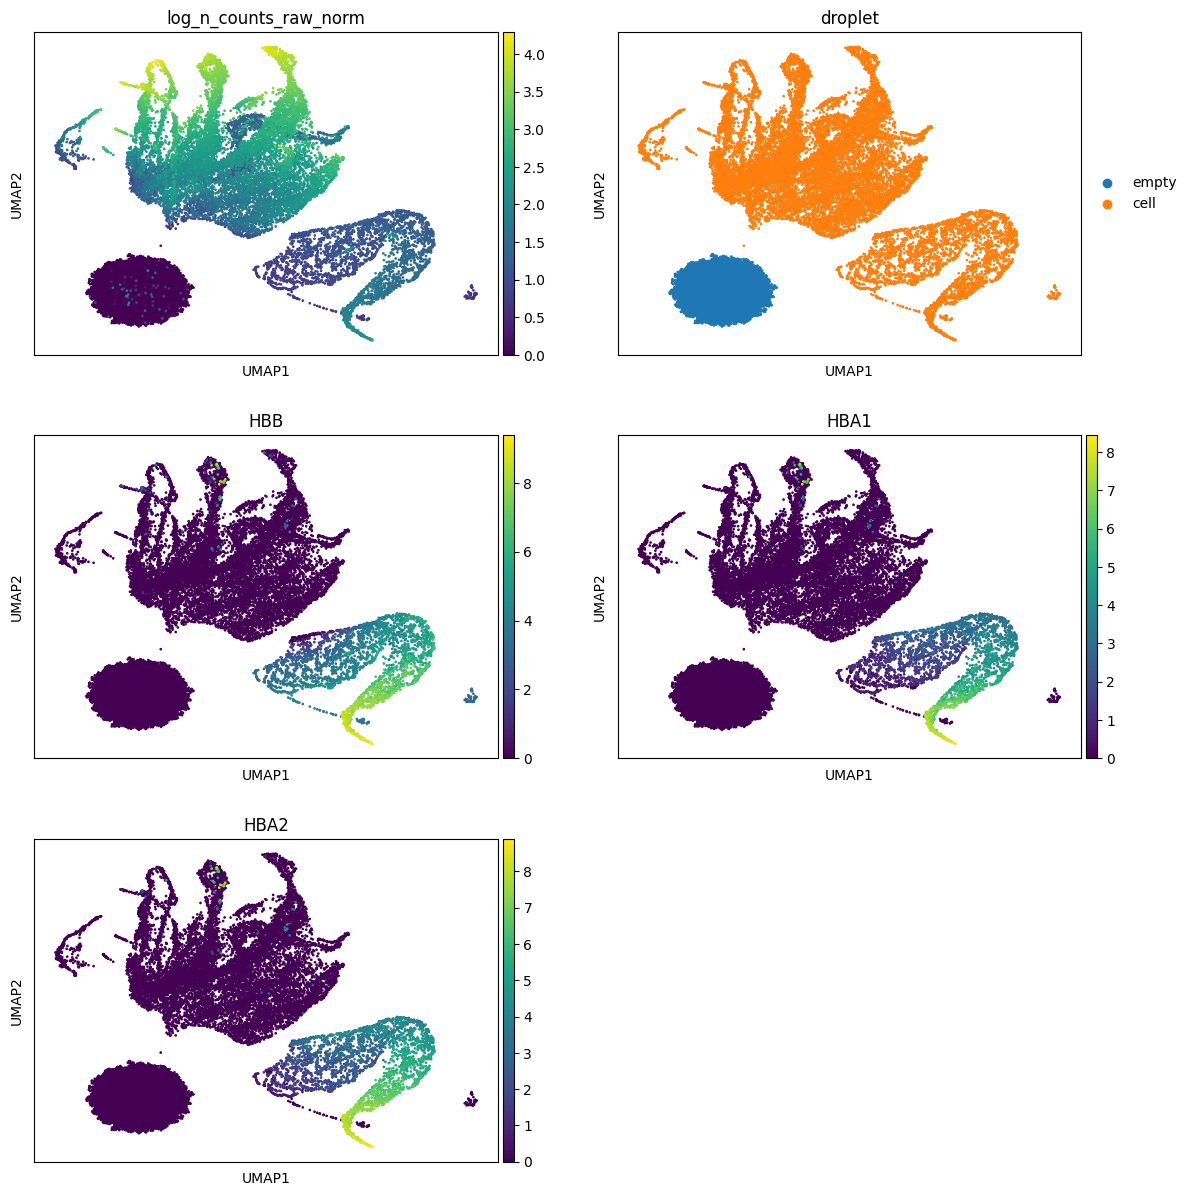

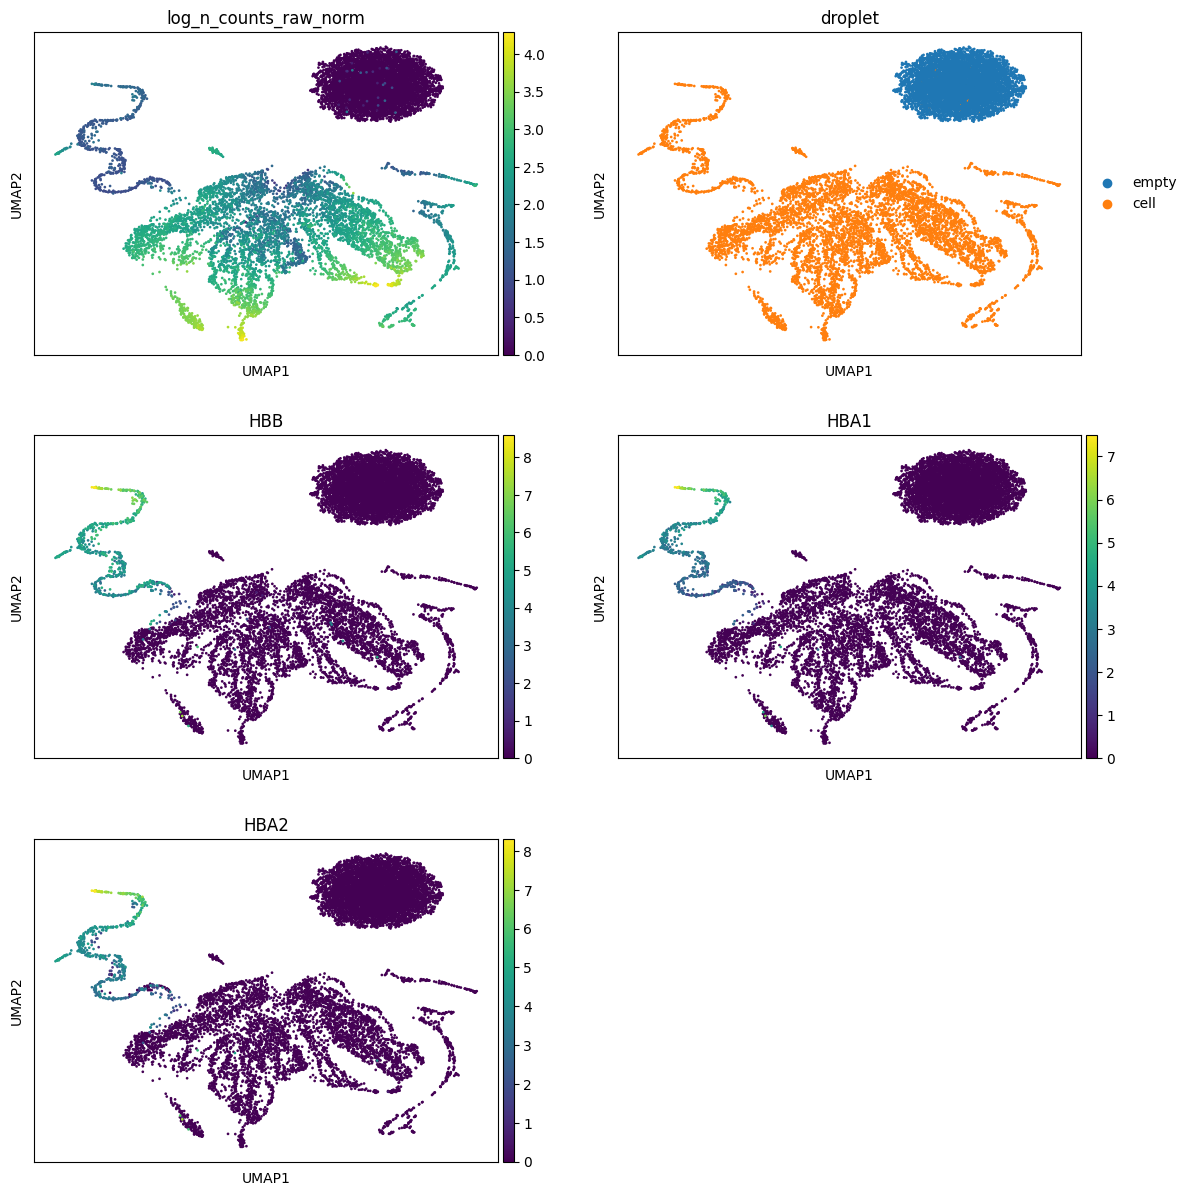

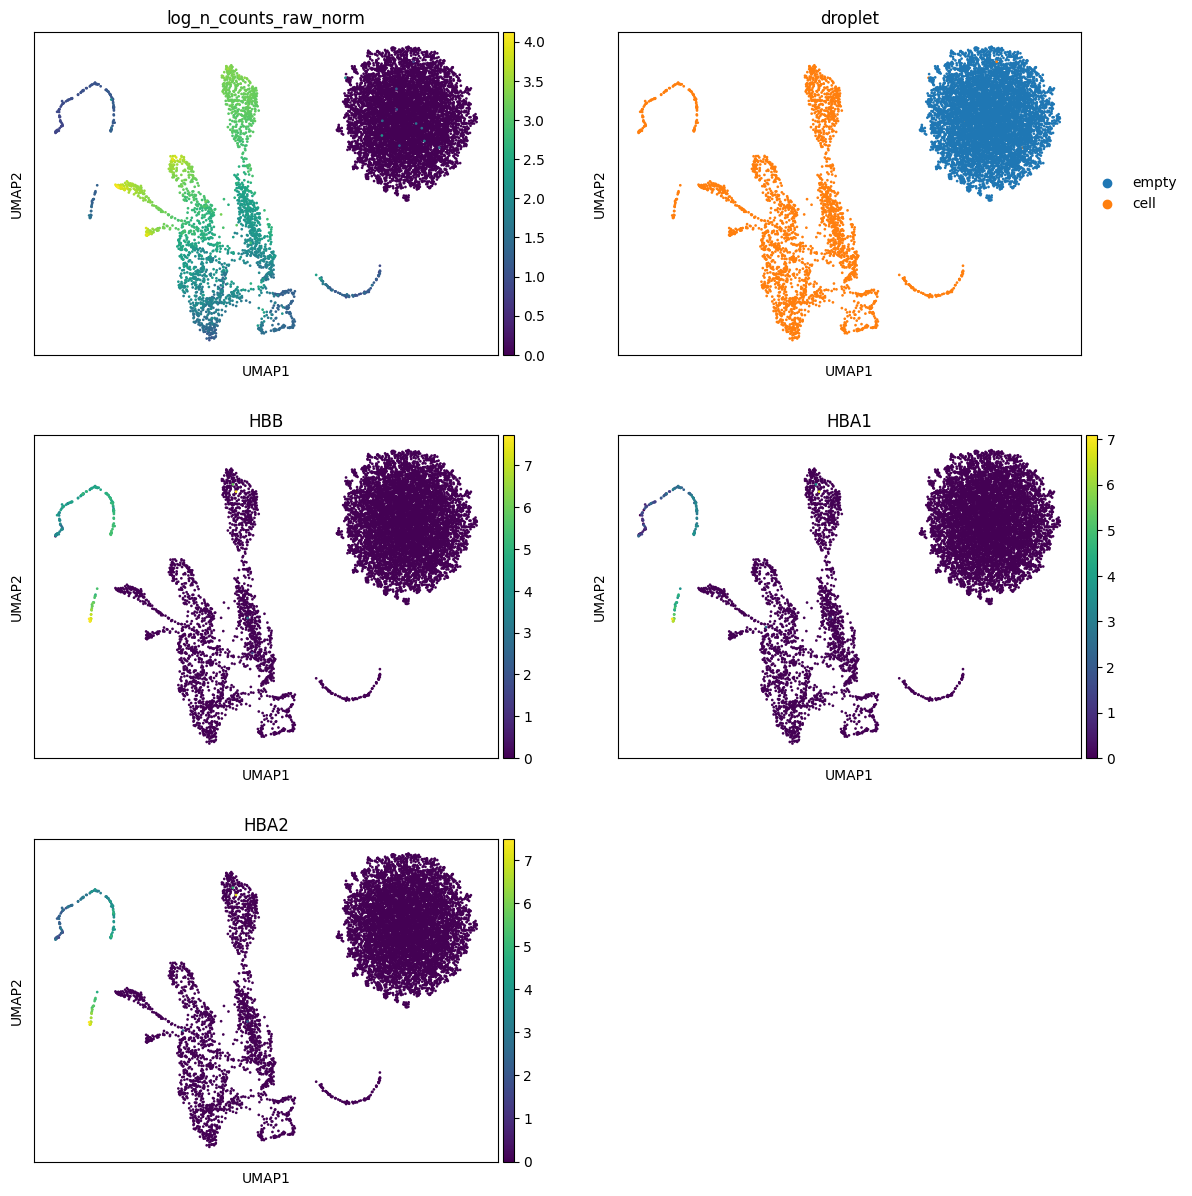

In [112]:
ery_genes=['log_n_counts_raw_norm','droplet','HBB','HBA1','HBA2']
rcParams['figure.figsize']=(6,4.5)

for batch in [*anndata_dict_norm][:]:
    adata_pp=anndata_dict_norm[batch]
    adata_pp.obs['droplet']=pd.cut(x=adata_pp.obs['cell_probability'],bins=[0,0.5,1],labels=['empty','cell'])
    sc.pl.umap(adata_pp, color=ery_genes,show=False,size=15,ncols=2,neighbors_key='X_umap')
